In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad, nquad
from matplotlib.colors import LinearSegmentedColormap

# Setup plotting style to match the "Viridis" style from the source
# Creating a custom color list based on the ViridisColor function in the source
colors = [
    (0.267, 0.005, 0.329), # Purple
    (0.229, 0.322, 0.545), # Blue
    (0.128, 0.567, 0.551), # Teal
    (0.369, 0.789, 0.383), # Green
    (0.993, 0.906, 0.144)  # Yellow
]
# Create a custom colormap if needed, or just select specific colors
# The source selects specific points: 0, 0.5, 1.0 (though the definition uses 0, 0.25, 0.5, 0.75, 1)
# We will pick 3 distinct colors for the plots as used in the legends (Purple, Teal, Yellowish)
plot_colors = [colors[0], colors[2], colors[4]] 

plt.rcParams.update({
    'font.size': 14,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
    'lines.linewidth': 2
})

In [2]:
# Unit Definitions (CGS)
cm = 1.0
s = 1.0
g = 1.0

km = 10**5 * cm
meter = 10**2 * cm
kg = 10**3 * g

pc = 3 * 10**18 * cm
kpc = 10**3 * pc
AU = 1.5 * 10**13 * cm

yr = np.pi * 10**7 * s
c = 3 * 10**10 * cm / s
GeV = 1.782662e-24 * g # Conversion to grams roughly, though used as density unit often

# Gravitational Constant (converted to CGS from the SI definition in source)
# Source: G = 6.67*10^-11 m^3 kg^-1 s^-2
G_SI = 6.67e-11
G = G_SI * (meter**3) / (kg * s**2) # results in approx 6.67e-8 cm^3 g^-1 s^-2

mSUN = 2 * 10**33 * g
Hz = 1.0 / s
GHz = 10**9 * Hz

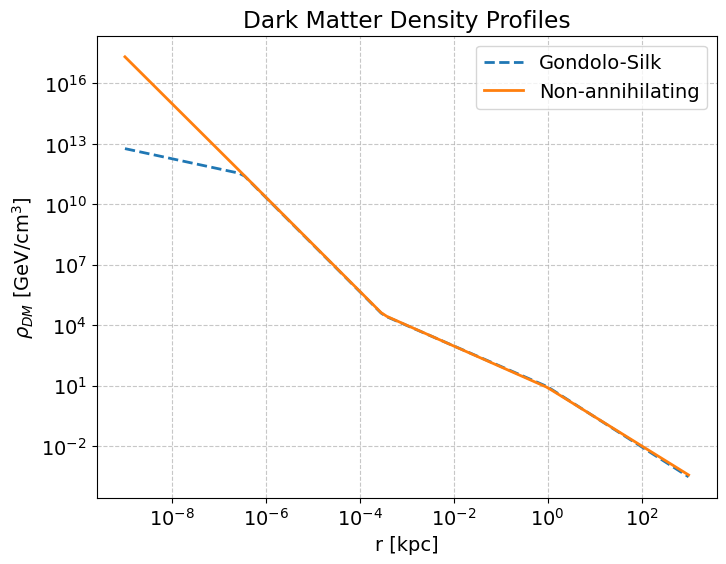

In [64]:
# --- Gondolo-Silk (GS) Profile ---
# Data points {r [kpc], rho [GeV/cm^3]} -> Log10 values
rho_data_GS = np.array([
    [10**-9.03, 10**12.78],
    [10**-6.50, 10**11.51],
    [10**-3.50, 10**4.50],
    [10**-0.01, 10**0.96],
    [8.0, 0.4]
])
log_rho_data_GS = np.log(rho_data_GS)

# Interpolation in Log-Log space
# We interpolate Log(rho) as a function of Log(r)
log_rho_DM_GS_interp = interp1d(
    log_rho_data_GS[:, 0], 
    log_rho_data_GS[:, 1], 
    kind='linear', 
    fill_value="extrapolate"
)

def rho_DM_GS(r_kpc):
    """Returns density in GeV/cm^3 given r in kpc."""
    # Handle scalar or array input
    r_val = np.array(r_kpc)
    # Clamp lower bound to avoid log(0) if necessary, though data starts at 10^-9
    r_val = np.maximum(r_val, 1e-10) 
    return np.exp(log_rho_DM_GS_interp(np.log(r_val))) # Result in GeV/cm^3


# --- Non-Annihilating (NA) Profile ---
rho_data_NA = np.array([
    [10**-9.10, 10**17.55],
    [10**-6.52, 10**11.57],
    [10**-3.50, 10**4.52],
    
    [10**-0.01, 10**0.92],
    [8.0, 0.4]
])
log_rho_data_NA = np.log(rho_data_NA)

log_rho_DM_NA_interp = interp1d(
    log_rho_data_NA[:, 0], 
    log_rho_data_NA[:, 1], 
    kind='linear', 
    fill_value="extrapolate"
)

def rho_DM_NA(r_kpc):
    """Returns density in GeV/cm^3 given r in kpc."""
    r_val = np.array(r_kpc)
    r_val = np.maximum(r_val, 1e-10)
    return np.exp(log_rho_DM_NA_interp(np.log(r_val)))


# Plotting the profiles to verify (reproducing Out[28])
r_plot = np.logspace(-9, 3, 100)
plt.figure(figsize=(8, 6))
plt.loglog(r_plot, rho_DM_GS(r_plot), label='Gondolo-Silk', linestyle='--')
plt.loglog(r_plot, rho_DM_NA(r_plot), label='Non-annihilating')
plt.xlabel("r [kpc]")
plt.ylabel(r"$\rho_{DM}$ [GeV/cm$^3$]")
plt.legend()
plt.title("Dark Matter Density Profiles")
plt.show()

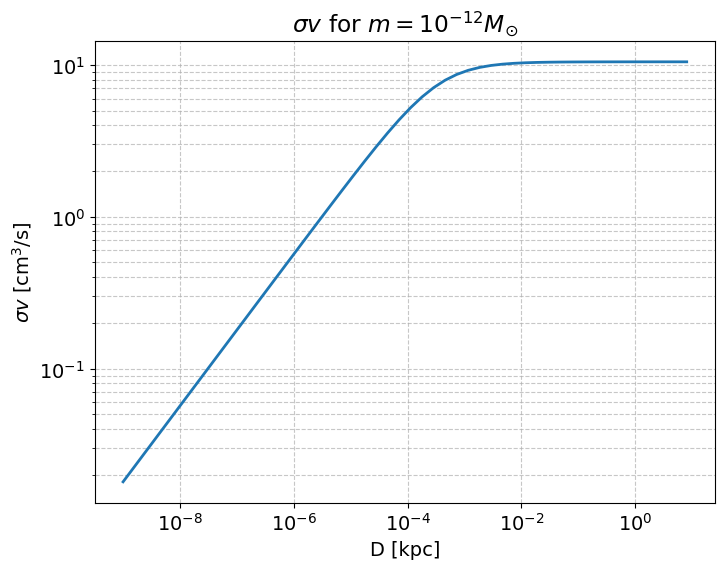

In [72]:
# PBH Parameters
fPBH = 1.0
msmbh = 4.3 * 10**6 * mSUN  # SMBH mass
Rgc = 8.0 * kpc             # Distance from Earth to Galactic Center

# PBH Number Density
# Note: rho is in GeV/cm^3. Need to convert m (grams) to GeV for consistency 
# OR convert rho to g/cm^3.
# 1 GeV ~ 1.78e-24 g.
# Source divides rho (GeV/cm^3) by m (grams). This implies m should be in GeV 
# or rho converted to g/cm^3.
# Looking at source: nBH = f * rho / m. 
# In source, m is input as grams (10^-10 mSUN). 
# However, the source sets `g=5.6*10^23 GeV`. This is a unit definition, likely 1 gram = 5.6e23 GeV.
# Let's convert density to CGS (g/cm^3) for the nPBH calculation to be clean.
GeV_in_grams = 1.78266192e-24

def nPBH(m_g, r_cm):
    """
    PBH number density at radius r.
    m_g: PBH mass in grams
    r_cm: distance from GC in cm
    Returns: number density in cm^-3
    """
    # Get density in GeV/cm^3
    rho_gev = rho_DM_NA(r_cm / kpc) 
    # Convert to g/cm^3
    rho_cgs = rho_gev * GeV_in_grams
    return fPBH * rho_cgs / m_g

def nPBH_halo(m_g):
    # Density in GeV/cm^3
    rho_gev = 0.4
    rho_cgs = rho_gev * GeV_in_grams
    return fPBH * rho_cgs / m_g

# Velocity Profile (Virial Velocity)
def v_virial(r_cm):
    """Virial velocity dominated by Sgr A* within 0.34 pc"""
    # r in cm
    # Avoid division by zero
    r_eff = np.maximum(r_cm, 1.0) 
    # Term 1: G * M_SMBH / r
    term1 = G * msmbh / r_eff
    # Term 2: G * M_SMBH / (0.34 pc) -> Constant addition? 
    # Source: G msmbh/r + G msmbh/(0.34 pc)
    # This looks like a potential well modification or cutoff
    term2 = G * msmbh / (0.34 * pc)
    return np.sqrt(term1 + term2)

# Scattering Cross Section
def sigma_v(m_g, r_cm):
    """
    PBH scattering cross section * velocity.
    Returns: sigma * v in [cm^3/s] (Wait, source plot says cm^2 * cm/s)
    """
    vel = v_virial(r_cm)
    # Geometric cross section: Pi * (2Gm/c^2)^2 * (c/v)^2
    # Gravitational focusing enhancement: (c/v)^2
    # Sigma = Pi * Rs^2 * (c/v)^2
    # Sigma * v = Pi * Rs^2 * c^2 / v
    
    rs = 2 * G * m_g / c**2
    sigma_geo = np.pi * rs**2
    focusing = (c / vel)**2
    
    sigma = sigma_geo * focusing
    return sigma * vel

# Plot Sigma*v to verify (reproducing Out[38] plot logic)
d_vals = np.logspace(-9, np.log10(8), 50)
sv_vals = [sigma_v(10**-12 * mSUN, d * kpc) for d in d_vals]

plt.figure(figsize=(8, 6))
plt.loglog(d_vals, sv_vals)
plt.xlabel("D [kpc]")
plt.ylabel(r"$\sigma v$ [cm$^3$/s]")
plt.title(r"$\sigma v$ for $m=10^{-12} M_{\odot}$")
plt.grid(True, which="both", linestyle='--')
plt.show()

In [73]:
# Geometry: Distance from GC given Earth distance D, angle theta
def r_from_GC(D_val, theta):
    """
    D_val: Distance from Earth (kpc)
    theta: Angle from GC direction (radians)
    Returns: Distance from GC (kpc)
    """
    # Law of cosines
    # r^2 = D^2 + Rgc^2 - 2*D*Rgc*cos(theta)
    # Rgc is defined globally as 8 kpc (in cm). Convert to kpc for this calc.
    Rgc_kpc = Rgc / kpc
    
    r2 = D_val**2 + Rgc_kpc**2 - 2 * D_val * Rgc_kpc * np.cos(theta)
    return np.sqrt(np.abs(r2)) # Sqrt of abs to handle numerical noise near 0

def rSafe(D_val, theta):
    # Clamp to 10^-9 kpc minimum
    val = r_from_GC(D_val, theta)
    return np.maximum(val, 1e-9)

# Differential Rate: dGamma/dD
# This is the event rate in a shell at distance D from Earth
def dGamma_dD_integrand(theta, m_g, D_kpc):
    """
    Integrand for dGamma/dD over theta.
    """
    D_cm = D_kpc * kpc
    
    # Get distance from GC
    r_kpc = rSafe(D_kpc, theta)
    r_cm = r_kpc * kpc
    
    # Calculate densities and cross section
    # Note: nPBH expects m in grams, r in cm. returns cm^-3
    # n = nPBH(m_g, r_cm)
    n = nPBH_halo(m_g)
    
    # sigma_v expects m in grams, r in cm. returns cm^3/s
    sv = sigma_v(m_g, r_cm)
    
    # Factor 0.5 to avoid double counting identical particles? Source has 0.5.
    # Volume element factor: 2 * Pi * D^2 * sin(theta)
    # The D^2 factor is outside the integral in the source definition dGamma/dD(D)
    # Wait, source: dGdD = Integrate[ 0.5 * n^2 * sv * 2Pi * D^2 * Sin[theta] ]
    
    val = 0.5 * (n**2) * sv * (2 * np.pi * D_cm**2 * np.sin(theta))
    return val

def dGamma_dD(m_g, D_kpc):
    """
    Returns differential rate [cm^-1 s^-1].
    """
    # Integrate theta from 0 to Pi
    result, error = quad(dGamma_dD_integrand, 0, np.pi, args=(m_g, D_kpc), limit=100)
    return result

# Total Rate Gamma (Cumulative)
# Integrate dGamma/dD from d=0 to d=D
def Gamma_total(m_g, D_kpc_limit):
    """
    Returns total rate [s^-1] inside sphere of radius D_kpc_limit.
    """
    # We integrate the dGamma_dD function over distance x from 0 to D_kpc_limit
    # The outer integral is over distance (in cm or kpc? Function takes kpc)
    # dGamma/dD returns rate per cm. 
    # We must integrate (dGamma/dD) * d(Distance).
    # If we integrate over x in kpc, we must multiply by (kpc/cm) factor?
    # No, dGamma_dD returns events per unit length (cm^-1 s^-1).
    # So Integral [ (dGamma/dD) * d(Distance_cm) ] is correct.
    # d(Distance_cm) = d(x_kpc) * kpc
    
    def integrand(x_kpc):
        return dGamma_dD(m_g, x_kpc) * kpc # convert dx to cm
        
    # Using quad for the outer integral
    # Warning: Nested integrals can be slow.
    result, error = quad(integrand, 0, D_kpc_limit, limit=50)
    return result

In [74]:
# Setup distance arrays (similar to source "dValues")
# Global: 10^-2 to 10^2
d_global = np.logspace(-2, 2, 41) 
# Zoom: 7.5 to 8.5
d_zoom = np.arange(3, 20, 0.01)
# Spike: Very close to 8.0
d_spike = np.linspace(7.0, 9.0, 100)

# Combine and sort unique values
d_values = np.unique(np.concatenate([d_global, d_zoom, d_spike]))
# Remove 0 or negative if any
d_values = d_values[d_values > 0]

mass_target = 10**-10 * mSUN

# Calculate dGamma/dD for f_PBH = 1
# This might take a minute or two due to numerical integration
print("Calculating dGamma/dD...")
rates_f1 = []
for d in d_values:
    # Calculate raw rate in cm^-1 s^-1
    val = dGamma_dD(mass_target, d)
    # Convert to units: [pc^-1 yr^-1]
    # cm^-1 -> pc^-1: multiply by pc
    # s^-1 -> yr^-1: multiply by yr
    val_converted = val * pc * yr
    
    rates_f1.append(val_converted)

rates_f1 = np.array(rates_f1)

# Scaling for other f_PBH fractions
# Rate is proportional to n^2, so proportional to f_PBH^2
# Source says: 
# f=1
# f=0.1 -> data * 10^-2
# f=0.01 -> data * 10^-4
rates_f01 = rates_f1 * 10**-2
rates_f001 = rates_f1 * 10**-4

Calculating dGamma/dD...


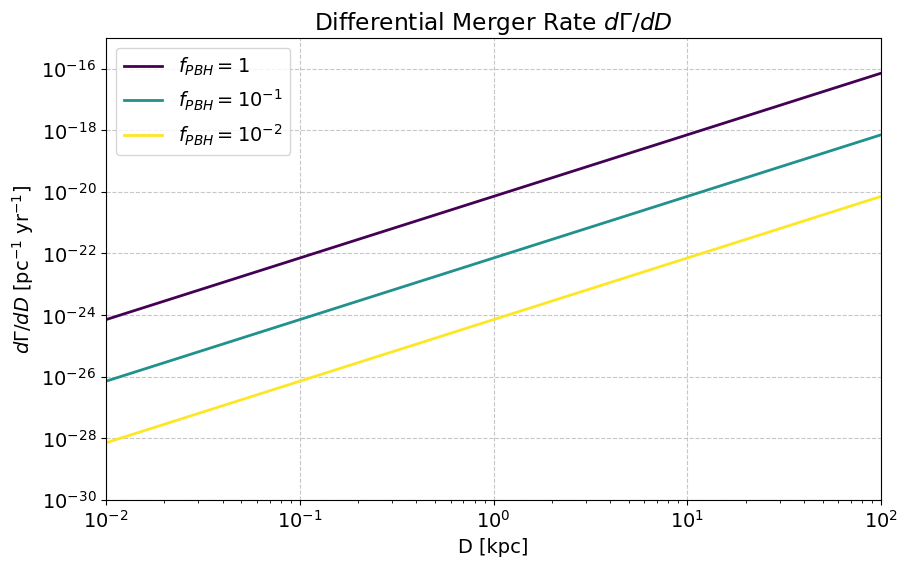

In [75]:
plt.figure(figsize=(10, 6))

plt.loglog(d_values, rates_f1, color=plot_colors[0], label=r'$f_{PBH}=1$')
plt.loglog(d_values, rates_f01, color=plot_colors[1], label=r'$f_{PBH}=10^{-1}$')
plt.loglog(d_values, rates_f001, color=plot_colors[2], label=r'$f_{PBH}=10^{-2}$')

plt.xlabel("D [kpc]")
plt.ylabel(r"$d\Gamma/dD$ [pc$^{-1}$ yr$^{-1}$]")
plt.title(r"Differential Merger Rate $d\Gamma/dD$")
plt.legend()
plt.xlim(1e-2, 1e2)
plt.ylim(1e-30, 1e-15) # Adjusted based on source plot appearance
plt.savefig("../figs/dGdD.svg", dpi=600)
plt.show()

In [76]:
# Setup distance arrays for Gamma calculation
d_values_gamma = np.unique(np.concatenate([d_global, d_zoom, d_spike]))
d_values_gamma = d_values_gamma[d_values_gamma > 0]

print("Calculating Gamma (Cumulative)...")
gamma_f1 = []

# Note: This loop performs a double integral for each point. 
# It may be slow. For a quick check, reduce the number of points in d_values_gamma.
for d in d_values_gamma:
    # Rate in s^-1
    val = Gamma_total(mass_target, d)
    # Convert to yr^-1
    val_converted = val * yr
    gamma_f1.append(val_converted)

gamma_f1 = np.array(gamma_f1)
gamma_f01 = gamma_f1 * 10**-2
gamma_f001 = gamma_f1 * 10**-4

Calculating Gamma (Cumulative)...


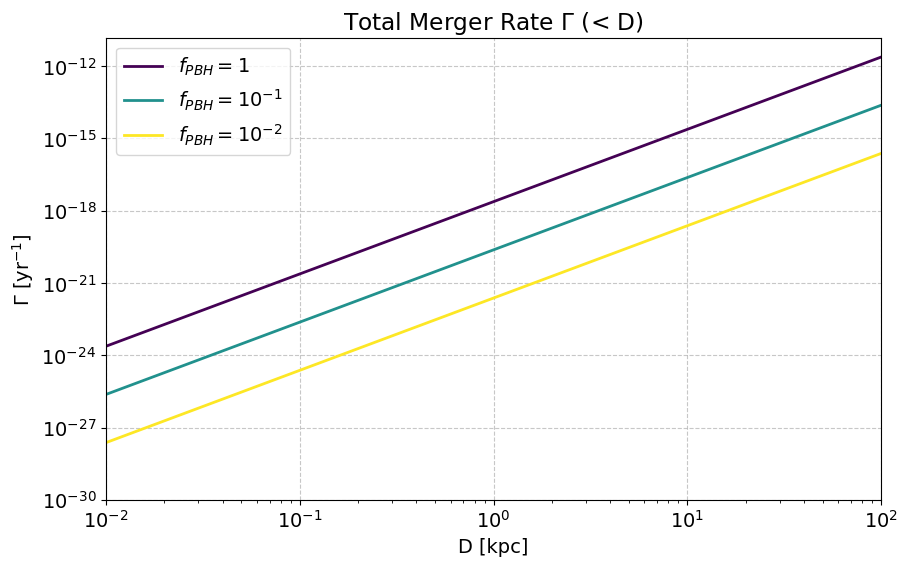

In [77]:
plt.figure(figsize=(10, 6))

plt.loglog(d_values_gamma, gamma_f1, color=plot_colors[0], label=r'$f_{PBH}=1$')
plt.loglog(d_values_gamma, gamma_f01, color=plot_colors[1], label=r'$f_{PBH}=10^{-1}$')
plt.loglog(d_values_gamma, gamma_f001, color=plot_colors[2], label=r'$f_{PBH}=10^{-2}$')

plt.xlabel("D [kpc]")
plt.ylabel(r"$\Gamma$ [yr$^{-1}$]")
plt.title(r"Total Merger Rate $\Gamma$ (< D)")
plt.legend()
plt.xlim(1e-2, 1e2)
# Set Y limits roughly based on source output or calculated magnitude
plt.ylim(bottom=1e-30) 
plt.savefig("../figs/Gamma.svg", dpi=600)
plt.show()